In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from statsmodels.stats import multitest
import gem_tools
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gemsubsys = gem_tools.read_gem_excel()['SUBSYSTEM']

In [3]:
groupdict = {
    'm-control': ('all_control', 'MSBB'),
    'm-AD': ('nosubtyping_AD', 'MSBB'),
    'm-AD-A': ('SubtypeA_AD', 'MSBB'),
    'm-AD-B1': ('SubtypeB1_AD', 'MSBB'),
    'm-AD-B2': ('SubtypeB2_AD', 'MSBB'),
    'm-AD-C1': ('SubtypeC1_AD', 'MSBB'),
    'm-AD-C2': ('SubtypeC2_AD', 'MSBB'),
    'r-control': ('all_control', 'ROSMAP'),
    'r-AD': ('nosubtyping_AD', 'ROSMAP'),
    'r-AD-A': ('SubtypeA_AD', 'ROSMAP'),
    'r-AD-B': ('SubtypeB_AD', 'ROSMAP'),
    'r-AD-C1': ('SubtypeC1_AD', 'ROSMAP'),
    'r-AD-C2': ('SubtypeC2_AD', 'ROSMAP'),
    'r-AD-other': ('Other_AD', 'ROSMAP'),
}

Take the coefficient of variation (CV) of the odds ratio (OR) across all subtypes, where $\mathrm{OR}\in \mathbb{R}$

In [4]:
def read_fisher_csv(AD_subtype, cohort='m'):
    prefix = '../../results/2023-02-06-AD-subtypes-active-reactions/fisher-exact-'
    fpath = prefix + AD_subtype + '_wrt_' + cohort + '-control.csv'
    df = pd.read_csv(fpath, index_col='rxn_ID')
    df.columns = pd.MultiIndex.from_product([[AD_subtype], df.columns])
    return(df)

def get_specificity_score_I(s):
    abs_of_sum = abs(s.dropna().sum())
    sum_of_abs = s.dropna().apply(abs).sum()
    specificity = 1 - abs_of_sum / sum_of_abs
    return(specificity)

def get_CV(s):
    ssdev = s.std(skipna=True) # sample std dev
    avg = s.mean(skipna=True)
    CV = ssdev / abs(avg)
    return(CV)

def AD_df(cohort='m', groupdict=groupdict):
    l = [read_fisher_csv(g, cohort=cohort) for g in groupdict.keys() if re.match(cohort + '-AD-.+', g)]
    df = pd.concat(l, axis=1)
    return(df)

def get_reaction_signif(df=AD_df(cohort='m'), method='fdr_bh', alpha=0.05):
    df = df.xs('p_value', level=1, axis=1)
    if method is None:
        signif = df.applymap(lambda x: x < alpha)
        return(signif)
    signif = df.apply(lambda x: pd.Series(multitest.multipletests(x, method=method, alpha=alpha)[0], index=df.columns), axis=1)
    return(signif)

def n_signif_rxn4pathway(df=AD_df(cohort='m'), method=None, alpha=0.05, gemsubsys=gemsubsys):
    signif = get_reaction_signif(df, method=method, alpha=alpha)
    n_signif_any = signif.any(axis=1)
    n_signif_subtype = pd.DataFrame(signif.to_numpy(), index=gemsubsys, columns=signif.columns).groupby('SUBSYSTEM').sum()
    return((n_signif_subtype, n_signif_any))

def get_specificity_scores(df=AD_df(cohort='m'), scorefun=get_CV, take_log2=False):
    df = df.xs('oddsratio', level=1, axis=1)
    df = df.replace(0, np.nan).replace(np.inf, np.nan).replace(-np.inf, np.nan)
    OR = df.copy()
    df = df.applymap(np.log2) if take_log2 else df
    scores = df.apply(scorefun, axis=1)
    return((scores, OR))

def aggregate_specificity_scores(scores_or_OR, gemsubsys=gemsubsys):
    val = scores_or_OR.copy()
    val.index = gemsubsys
    #s = pd.Series(scores.to_numpy(), index=gemsubsys)
    val = val.groupby('SUBSYSTEM').mean()#.sort_values(ascending=False)
    return(val)

In [5]:
def process_n_signif(cohort='m', method=None, alpha=0.05, scorefun=get_CV, do_sort=True, to_drop=None):
    n_signif_subtype, n_signif_any = n_signif_rxn4pathway(AD_df(cohort=cohort), method=method, alpha=alpha)
    df = n_signif_subtype.loc[n_signif_subtype.max(axis=1) >= 3]
    scores, OR = get_specificity_scores(df=AD_df(cohort=cohort), scorefun=scorefun)
    # first: process scores
    scores.loc[~ n_signif_any] = np.nan
    scores = aggregate_specificity_scores(scores).to_frame('avg. specificity')
    n_signif = pd.concat([df, scores], axis=1, join='inner')
    n_signif = n_signif.sort_values('avg. specificity', ascending=True) if do_sort else n_signif
    n_signif = n_signif.drop(to_drop, axis=0) if to_drop is not None else n_signif
    # second: process odds ratios
    OR.loc[~ n_signif_any] = np.nan
    OR = aggregate_specificity_scores(OR)
    OR = OR.loc[n_signif.index]
    return((n_signif, OR))

n_signif, OR = process_n_signif(to_drop=['Transport reactions', 'Exchange/demand reactions'])
pd.concat([n_signif, OR], axis=1)

,m-AD-A,m-AD-B1,m-AD-B2,m-AD-C1,m-AD-C2,avg. specificity,m-AD-A,m-AD-B1,m-AD-B2,m-AD-C1,m-AD-C2
SUBSYSTEM,,,,,,,,,,,
Acyl-CoA hydrolysis,0,0,0,38,3,0.137681,NaN,NaN,NaN,0.105021,0.135921
Beta oxidation of even-chain fatty acids (mitochondrial),0,3,0,0,0,0.476473,0.781250,0.151515,0.416667,0.617284,0.500000
Propanoate metabolism,3,0,0,0,0,0.526167,0.276786,1.571429,1.285714,1.619048,NaN
Chondroitin / heparan sulfate biosynthesis,0,0,2,5,0,0.585966,0.738880,0.968603,2.712088,3.205195,1.582051
Glycosphingolipid biosynthesis-globo series,1,1,3,0,0,0.632434,1.558702,1.429825,4.057749,2.183297,1.636087
Arginine and proline metabolism,0,1,2,4,4,0.651469,1.342964,2.511935,2.794524,3.142476,2.973920
"Phenylalanine, tyrosine and tryptophan biosynthesis",2,4,1,10,1,0.662090,1.087732,0.456829,1.561472,3.772892,2.953021
Tyrosine metabolism,1,3,1,1,1,0.720972,1.100999,1.907946,0.929688,0.888825,0.173913
Keratan sulfate degradation,0,16,0,0,0,0.722350,2.002933,NaN,0.646505,0.980988,1.860556


['named-figure/avg-OR-MSSM.png', 'named-figure/avg-OR-MSSM.pdf']

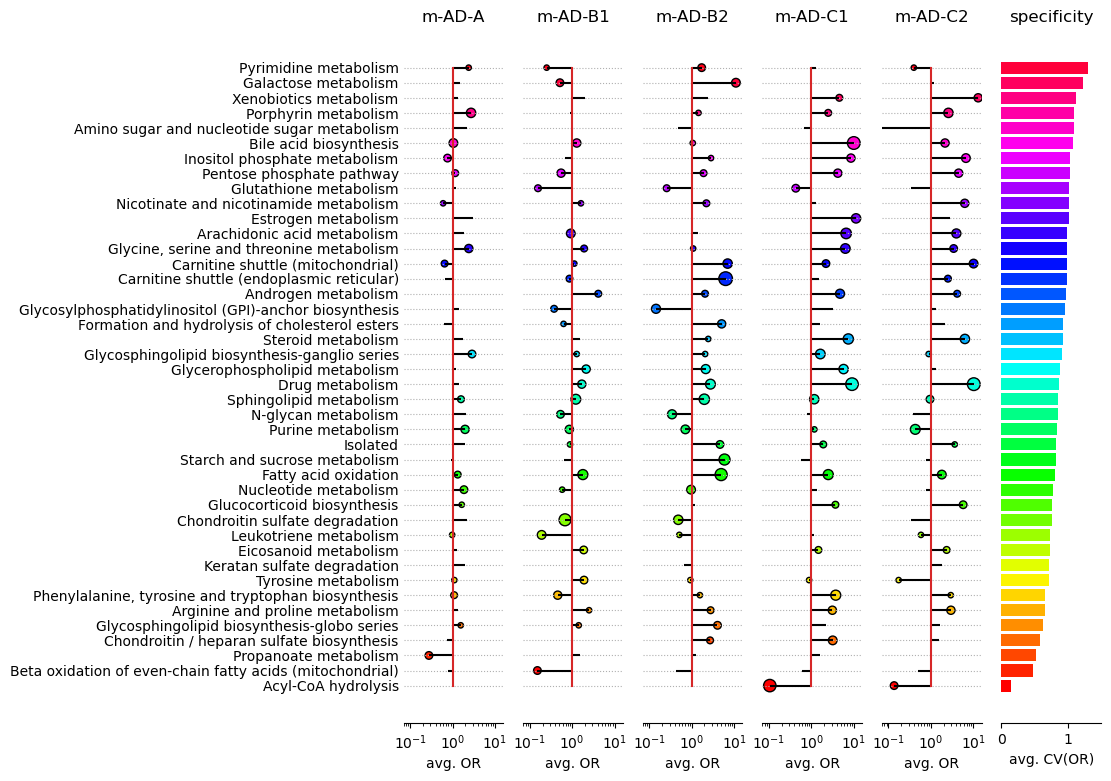

In [6]:
fig, ax = plt.subplots(1, n_signif.shape[1], sharey=True, figsize=(9,9))
yticks = list(range(n_signif.shape[0]))
for axi, col in zip(ax[:-1], OR.columns):
    marker_size = np.log10(n_signif[col] + 1) * 50
    axi.stem(col, data=OR, orientation='horizontal', bottom=1, markerfmt='C0 ', linefmt='k-')
    axi.scatter(x=col, y=yticks, s=marker_size, c=yticks, data=OR, edgecolors='black', cmap='hsv')
    #axi.barh(width=col, y=yticks, data=n_signif)
    axi.set_yticks(yticks)
    axi.set_yticklabels(n_signif.index)
    axi.tick_params(axis='y', length=0)
    axi.grid(axis='y', linestyle='dotted')
    axi.set_title(col)
    axi.set_xscale('log')
    axi.set_xlim([0.07, OR.abs().max().max() * 1.2])
    axi.set_xlabel(r'avg. OR')
axi = ax[-1]
axi.barh(width='avg. specificity', y=yticks, data=n_signif, color=matplotlib.colormaps['hsv'](np.array(yticks) / len(yticks)))
axi.set_xlim([0, 1.5])
axi.tick_params(axis='y', length=0)
axi.set_title('specificity')
axi.set_xlabel(r'avg. CV(OR)')
sns.despine(left=True, bottom=False)
attila_utils.savefig(fig, 'avg-OR-MSSM')

In [7]:
%connect_info

{
  "shell_port": 54514,
  "iopub_port": 54515,
  "stdin_port": 54516,
  "control_port": 54518,
  "hb_port": 54517,
  "ip": "127.0.0.1",
  "key": "66862464-b3cedd2441e8a10e07f3d640",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-abf21b5e-2edb-4565-96a6-8a2996d439f3.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
